In [72]:
from PIL import Image
import numpy as np
import pylab as pl
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib
from scipy.cluster.vq import *
import pandas as pd
import time
import matplotlib.pyplot as plt


In [2]:
def Load_data():
    # Load the data
    # Path: data_processing.ipynb
    # Return: data, label
    Vectors = np.loadtxt('./digits4000_txt/digits4000_txt/digits4000_digits_vec.txt')
    Labels = np.loadtxt('./digits4000_txt/digits4000_txt/digits4000_digits_labels.txt')
    # train_X,test_X,train_y,test_y = train_test_split(Vectors, Labels, test_size=0.5)
    return Vectors, Labels

SIFT features extraction

In [3]:
def Trans_data2img(x_img):
    # transform the nparray into cv image in gray
    image = Image.fromarray(x_img.reshape(28,28).astype(np.uint8))
    img = cv.cvtColor(np.asarray(image),cv.COLOR_RGB2BGR)
    return img


def SIFT_extraction(img, threshold):
    sift = cv.SIFT_create(threshold)
    kps, features = sift.detectAndCompute(img, None)
    return features

def Learn_vocabulary(features, K=150):
    # K is number of the clusters
    #set the convergence criteria for kmeans
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    #set the initail centroids for kmeans
    flags = cv.KMEANS_RANDOM_CENTERS

    compactness, labels, centroids = cv.kmeans(features, int(K), None, criteria, 10, flags)
    return centroids


def Set_centroids(X, threshold, K=150):
    features = []
    for x_img in X:
        img = Trans_data2img(x_img)
        # extract the SIFT features
        img_features = SIFT_extraction(img, threshold)
        if img_features is not None:
            features.append(img_features)
    features = np.vstack(features)

    #learn the centroids by kmeans
    centroids = Learn_vocabulary(features, K)
    # save the centroids for training
    filename = "./SIFT_FX/SIFT_centroids.npy"
    np.save(filename, centroids)
    print('vocabular package:',centroids.shape)
    return centroids

def Get_featureVec(features, centers, K=150):
    featureVec = np.zeros((1, K))
    for feature in features:
        feature = np.float32(feature)
        index = (np.sum((centers - feature) ** 2, axis=1)).argmin()
        featureVec[0][index] += 1
    return featureVec

def Get_Vecs_from_SIFT(X, y, threshold, K=150):
    centroids = np.load('./SIFT_FX/SIFT_centroids.npy')
    SIFT_vecs = []
    labels = []
    for i in range(X.shape[0]):
        img = Trans_data2img(X[i])
        # extract the SIFT features
        img_features = SIFT_extraction(img, threshold)
        # get the feature vector
        if img_features is not None:
            img_vec = Get_featureVec(img_features, centroids, K)
            SIFT_vecs.append(img_vec)
            labels.append(y[i])
    SIFT_vecs = np.vstack(SIFT_vecs)
    print('data_vec:',SIFT_vecs.shape)
    print('image features vector done!')
    return SIFT_vecs, labels 


PCA

In [4]:
def PCA_reduction(X, n_components=0.95):
    # n_components: to statisfy the variance percentage
    pca = PCA(n_components=n_components, svd_solver='full')
    X_pca = pca.fit_transform(X)
    print('PCA reduction done!')
    return X_pca

kernel PCA

In [5]:
def kPCA_reduction(X, n_components=147):
    # n_components: to statisfy the variance percentage
    kpca = KernelPCA(n_components=n_components)
    X_kpca = kpca.fit_transform(X)
    print('kPCA reduction done!')
    return X_kpca

LDA

In [49]:
# def LDA_reduction(X, y, n_components=9):
#     # n_components: number of components to keep
#     lda = LDA(n_components=n_components)
#     X_lda = lda.fit_transform(X, y)
#     print('LDA reduction done!')
#     return X_lda
def LDA_train(X, y):
    clf = LDA(n_components=9)
    clf.fit(X, y)
    return clf


In [ ]:
def LogisticRegression_train(X, y):
    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

In [7]:
def TSNE_reduction(X, n_components=2):
    # n_components: number of components to keep
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    print('TSNE reduction done!')
    return X_tsne

In [76]:
def SVM_train(X, y):
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X, y)
    return clf

def Perceptron_train(X, y):
    clf = Perceptron(tol=1e-3, random_state=0)
    clf.fit(X, y)
    return clf

def KNN_train(X, y):
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X, y)
    return clf

def LogisticRegression_train(X, y):
    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

def NaiveBayesian_train(X, y):
    clf = MultinomialNB()
    clf.fit(X, y)
    return clf    

def test(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # print('accuracy:', accuracy)
    return accuracy

In [74]:
def model_train_test(X,y,model='SVM', data_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_size)
    if model == 'SVM':
        clf = SVM_train(X_train, y_train)
    elif model == 'Perceptron':
        clf = Perceptron_train(X_train, y_train)
    elif model == 'KNN':
        clf = KNN_train(X_train, y_train)
    elif model == 'LogisticRegression':
        clf = LogisticRegression_train(X_train, y_train)
    elif model == 'BayesianRidge':
        clf = NaiveBayesian_train(X_train, y_train)
    accuracy = test(clf, X_test, y_test)
    return accuracy

In [51]:
def SVM_train_test(X,y, decom='', data_size=0.5):
    # decom: PCA, LDA, SIFT
    # data_size: the size of the data
    if decom == 'None':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_size)
        t1 = time.time()
        clf = SVM_train(X_train, y_train)
        t2 = time.time()
        accuracy = test(clf, X_test, y_test)
        shape = X_train.shape[1]
    elif decom == 'PCA':
        X = PCA_reduction(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_size)
        t1 = time.time()
        clf = SVM_train(X_train, y_train)
        t2 = time.time()
        accuracy = test(clf, X_test, y_test)
        shape = X_train.shape[1]
    elif decom == 'SIFT':
        Set_centroids(X[:1000, :], 25)
        X,y = Get_Vecs_from_SIFT(X, y, 25)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_size)
        t1 = time.time()
        clf = SVM_train(X_train, y_train)
        t2 = time.time()
        accuracy = test(clf, X_test, y_test)
        shape = X_train.shape[1]
    elif decom == 'LDA':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_size)
        t1 = time.time()
        clf = LDA_train(X_train, y_train)
        t2 = time.time()
        accuracy = test(clf, X_test, y_test)
        shape = 9

    return accuracy, t2-t1, shape

In [52]:
X, y = Load_data()
decom_list = ['None', 'PCA', 'LDA', 'SIFT']
accuracy_dict = {}
time_dict = {}
feature_dict = {}
for decom in decom_list:
    accuracy_list, time_list, feature_list = [], [], []
    size_metrics_dict = {}
    for i in range (10):
        accuracy, time_cost, feature_shape = SVM_train_test(X, y, decom)
        accuracy_list.append(accuracy)
        time_list.append(time_cost)
        feature_list.append(feature_shape)
    print('decom:', decom) 
    print('accuracy:', np.mean(accuracy_list))
    print('time:', np.mean(time_list))
    print('feature:', np.max(feature_list))
    accuracy_dict[decom] = np.mean(accuracy_list)
    time_dict[decom] = np.mean(time_list)
    feature_dict[decom] = np.max(feature_list)


accuracy: 0.939
accuracy: 0.9405
accuracy: 0.938
accuracy: 0.9415
accuracy: 0.946
accuracy: 0.936
accuracy: 0.935
accuracy: 0.9385
accuracy: 0.936
accuracy: 0.9415
decom: None
accuracy: 0.9391999999999999
time: 0.3099757432937622
feature: 784
PCA reduction done!
accuracy: 0.9495
PCA reduction done!
accuracy: 0.946
PCA reduction done!
accuracy: 0.9475
PCA reduction done!
accuracy: 0.9425
PCA reduction done!
accuracy: 0.9535
PCA reduction done!
accuracy: 0.949
PCA reduction done!
accuracy: 0.958
PCA reduction done!
accuracy: 0.9505
PCA reduction done!
accuracy: 0.9445
PCA reduction done!
accuracy: 0.9485
decom: PCA
accuracy: 0.94895
time: 0.19544970989227295
feature: 147
accuracy: 0.797
accuracy: 0.7905
accuracy: 0.779
accuracy: 0.775
accuracy: 0.7935
accuracy: 0.7985
accuracy: 0.773
accuracy: 0.7875
accuracy: 0.784
accuracy: 0.7885
decom: LDA
accuracy: 0.78665
time: 0.21773099899291992
feature: 9
vocabular package: (150, 128)
data_vec: (3921, 150)
image features vector done!
accuracy: 0

In [ ]:
X, y = Load_data()
model_list = ['SVM', 'Perceptron', 'KNN', 'LogisticRegression', 'BayesianRidge']
data_size_list = [0.1, 0.25, 0.5, 0.75]
model_data_size_dict = {}
for model in model_list:
    datasize_accuracy_dict = {}
    for data_size in data_size_list:
        accuracy_list = []
        for i in range (10):
            accuracy = model_train_test(X, y, model, data_size)
            accuracy_list.append(accuracy)
        print('model:', model)
        print('data_size:', data_size)
        print('accuracy:', np.mean(accuracy_list))
        datasize_accuracy_dict[1-data_size] = np.mean(accuracy_list)
    model_data_size_dict[model] = datasize_accuracy_dict

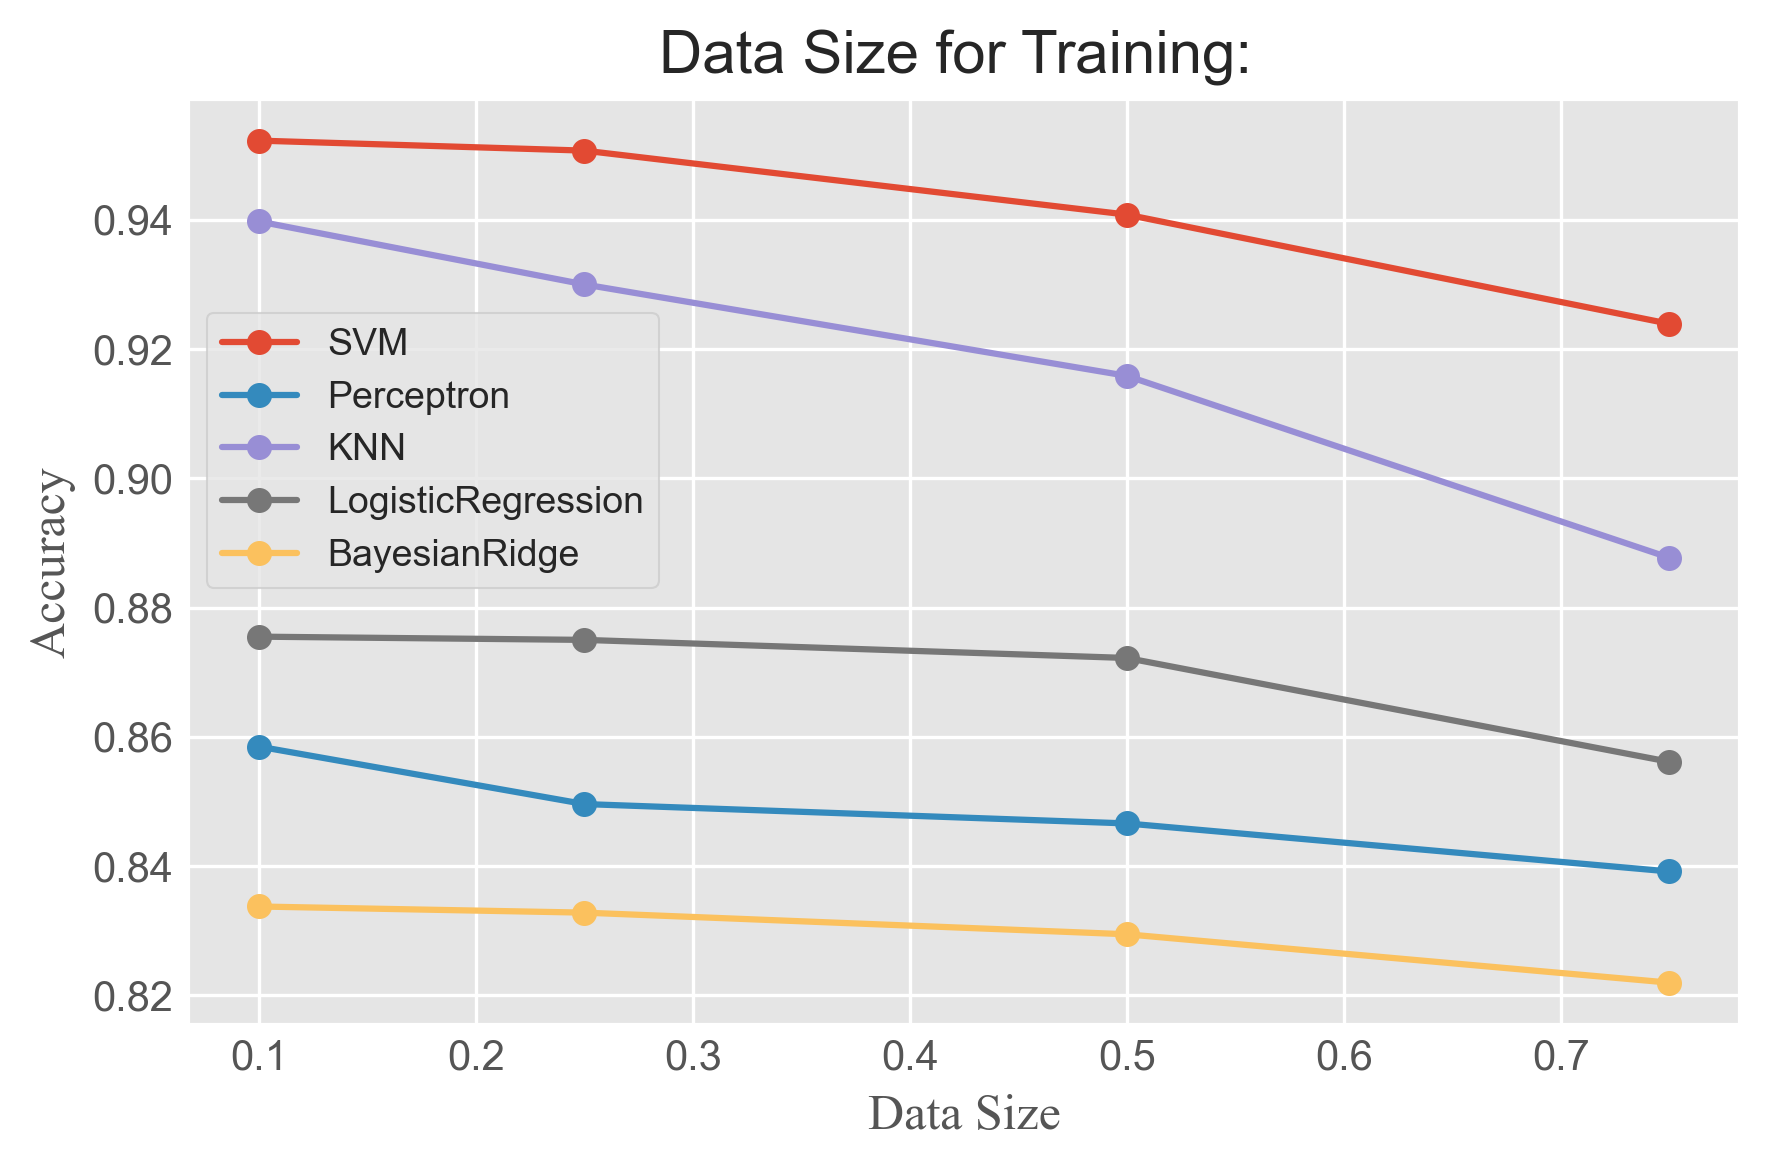

In [112]:
font = {"size": 12,
        "family": 'Times New Roman'}

plt.style.use(style='ggplot')
plt.figure(figsize=(6, 4), dpi=300)
for key, value in model_data_size_dict.items():
    # plt.subplot(2, 2, count)
    plt.plot(list(value.keys()), list(value.values()), label=key, marker='.', markersize=10)

    plt.title('Data Size for Training: ')  
plt.ylabel('Accuracy', fontdict=font)
plt.xlabel('Data Size', fontdict=font)  
plt.legend(loc=6, fontsize=9, frameon=True, bbox_to_anchor=(0,0.62))
plt.tight_layout()

<BarContainer object of 4 artists>

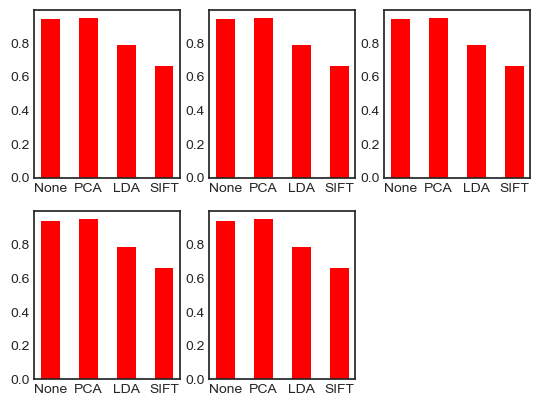

In [65]:
plt.subplot(2, 3, 1)
plt.bar(range(len(accuracy_dict)), accuracy_dict.values(), width=0.5 ,tick_label = decom_list, color='r')

plt.subplot(2, 3, 2)
plt.bar(range(len(accuracy_dict)), accuracy_dict.values(), width=0.5 ,tick_label = decom_list, color='r')

plt.subplot(2, 3, 3)
plt.bar(range(len(accuracy_dict)), accuracy_dict.values(), width=0.5 ,tick_label = decom_list, color='r')

plt.subplot(2, 3, 4)
plt.bar(range(len(accuracy_dict)), accuracy_dict.values(), width=0.5 ,tick_label = decom_list, color='r')
plt.subplot(2, 3, 5)
plt.bar(range(len(accuracy_dict)), accuracy_dict.values(), width=0.5 ,tick_label = decom_list, color='r')

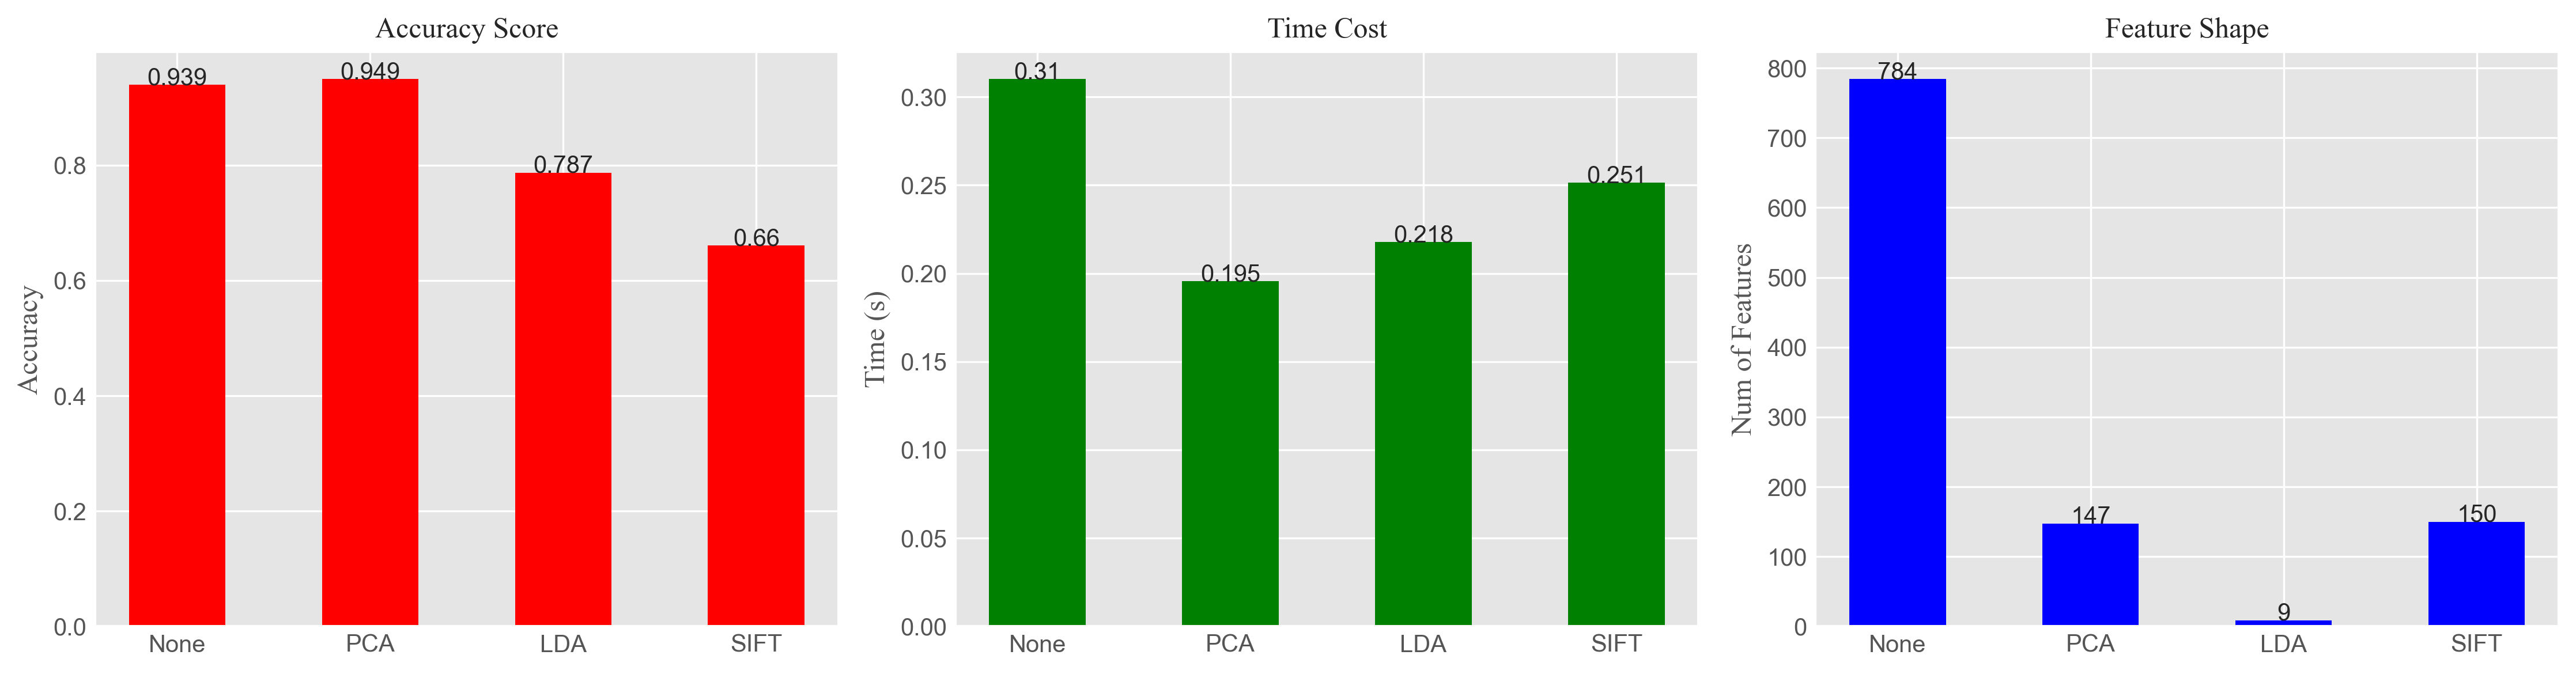

In [99]:
font = { "size": 12, 
        "family" : 'Times New Roman'}

plt.style.use(style='ggplot')
plt.figure(figsize=(15,4),dpi=300)

plt.subplot(1, 3, 1) 
plt.bar(range(len(accuracy_dict)), accuracy_dict.values(), width=0.5 ,tick_label = decom_list, color='r')
plt.title('Accuracy Score', fontdict=font)
plt.ylabel('Accuracy', fontdict=font)
for x,y in zip(range(len(accuracy_dict)),accuracy_dict.values()):
    plt.text(x,y,round(y,3), horizontalalignment='center')
# cbar = plt.colorbar(ticks=range(10)) 
# cbar.set_label(label='digit value', fontdict=font)
# plt.clim(-0.5, 9.5)

plt.subplot(1, 3, 2) 
plt.bar(range(len(time_dict)), time_dict.values(), width=0.5, tick_label = decom_list, color='g')
plt.title('Time Cost', fontdict=font)
plt.ylabel('Time (s)', fontdict=font)
for x,y in zip(range(len(time_dict)),time_dict.values()):
    plt.text(x,y,round(y,3), horizontalalignment='center')
# cbar = plt.colorbar(ticks=range(10)) 
# cbar.set_label(label='digit value', fontdict=font)
# plt.clim(-0.5, 9.5)

plt.subplot(1, 3, 3) 
plt.bar(range(len(feature_dict)), feature_dict.values(), width=0.5, tick_label = decom_list, color='b')
plt.title('Feature Shape', fontdict=font)
plt.ylabel('Num of Features', fontdict=font)
for x,y in zip(range(len(feature_dict)),feature_dict.values()):
    plt.text(x,y,round(y,3), horizontalalignment='center')
# cbar = plt.colorbar(ticks=range(10)) 
# cbar.set_label(label='digit value', fontdict=font)
plt.tight_layout()


In [ ]:
data_size = [0.1, 0.25, 0.5, 0.75, 1]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
t1 = time.time()
test(SVM_train(X_train, y_train), X_test, y_test)
t2 = time.time()
print('normal training time:', t2-t1)

accuracy: 0.8935
normal training time: 1.8690557479858398


In [38]:
X_train, X_test, y_train, y_test = train_test_split(PCA_reduction(X,.95), y, test_size=0.5)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
t1 = time.time()
test(SVM_train(X_train, y_train), X_test, y_test)
t2 = time.time()
print('After PCA reduction, training time:', t2-t1)

PCA reduction done!
accuracy: 0.9045
After PCA reduction, training time: 0.8457283973693848


In [39]:
X_train, X_test, y_train, y_test = train_test_split(kPCA_reduction(X, 147), y, test_size=0.5)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
t1 = time.time()
test(SVM_train(X_train, y_train), X_test, y_test)
t2 = time.time()
print('After kPCA reduction, training time:', t2-t1)

kPCA reduction done!
accuracy: 0.9125
After kPCA reduction, training time: 0.8088929653167725


In [40]:
X_train, X_test, y_train, y_test = train_test_split(LDA_train(X,y, 9), y, test_size=0.5)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
t1 = time.time()
test(SVM_train(X_train, y_train), X_test, y_test)
t2 = time.time()
print('After LDA reduction, training time:', t2-t1)

LDA reduction done!
accuracy: 0.937
After LDA reduction, training time: 0.21038031578063965


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(TSNE_reduction(X, 2), y, test_size=0.5)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
t1 = time.time()
test(SVM_train(X_train, y_train), X_test, y_test)
t2 = time.time()
print('After t-SNE reduction, training time:', t2-t1)

In [ ]:
X_train.shape
print(X_train)

c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


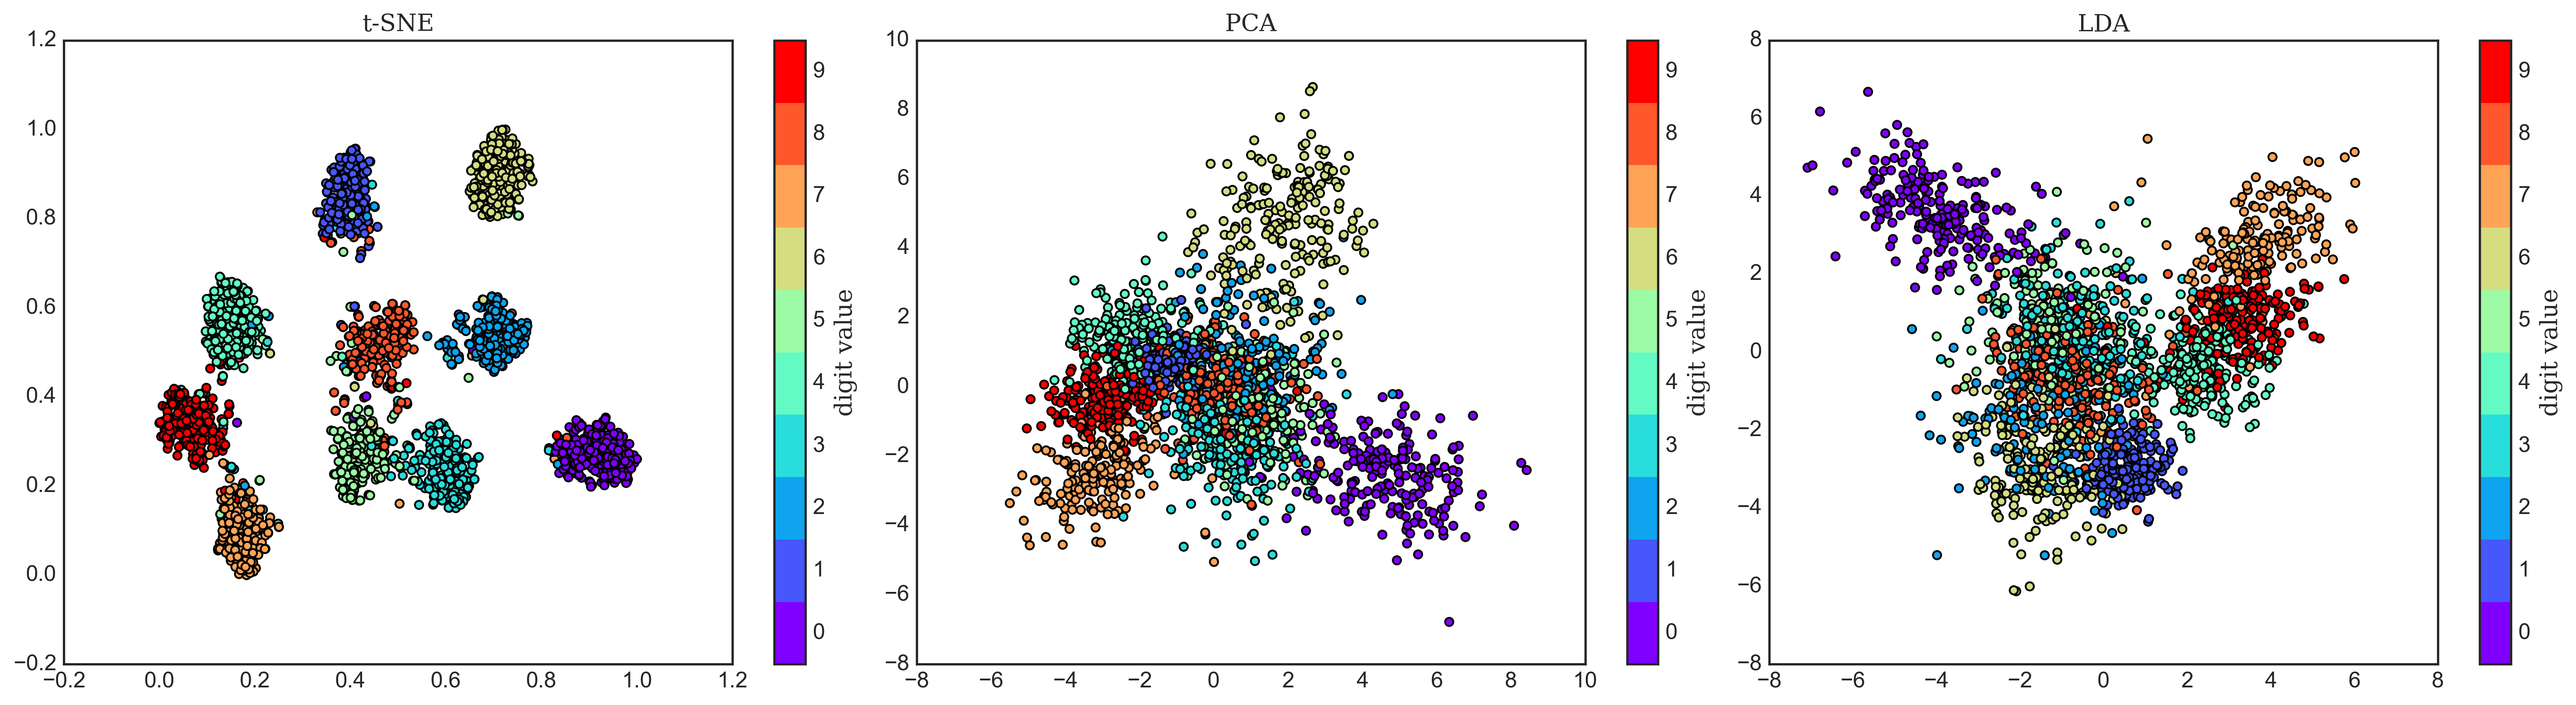

In [28]:

# %config InlineBackend.figure_format = "svg"

X_tsne = TSNE(n_components=2,init='pca').fit_transform(X_train)
X_pca = PCA(n_components=2).fit_transform(X_train)
X_lda = LDA(n_components=2).fit_transform(X_train, y_train)


x_min,x_max = np.min(X_tsne,0),np.max(X_tsne,0)
data = (X_tsne-x_min)/(x_max-x_min)

font = { "size": 13, 
        "family" : "serif"}

plt.style.use('seaborn-white')
plt.figure(figsize=(20, 5.5),dpi=300)
plt.subplot(1, 3, 1) 
plt.scatter(data[:, 0], data[:, 1], c=y_train, 
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.title("t-SNE", fontdict=font)
cbar = plt.colorbar(ticks=range(10)) 
cbar.set_label(label='digit value', fontdict=font)
plt.clim(-0.5, 9.5)

plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.title("PCA", fontdict=font)
cbar = plt.colorbar(ticks=range(10)) 
cbar.set_label(label='digit value', fontdict=font)
plt.clim(-0.5, 9.5)
plt.tight_layout()


plt.subplot(1, 3, 3)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_train, 
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.title("LDA", fontdict=font)
cbar = plt.colorbar(ticks=range(10)) 
cbar.set_label(label='digit value', fontdict=font)
plt.clim(-0.5, 9.5)
plt.tight_layout()